# Final Transit Parameters

This code was begun on 29 June, 2015

In [62]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy as sp
from scipy.optimize import curve_fit
import emcee
import triangle
import glob, os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Properties of the planet candidate and its host star (except period and t0)

In [63]:
#Properties of Planet Candidate (Data taken from Spreadsheet)
depth = 0.15*0.01 # (In absolute terms)
ecc = 0.0
b = 0.5
Rp = 3.47 
Mp = 31.87

#Star properties (from http://arxiv.org/pdf/1503.07866v1.pdf)
mass = 0.93
masserr = (0.05+0.06)/2.0
radius = 0.93
radiuserr = (0.05+0.06)/2.0
Teff = 5553

# From Claret (From Roberto's USPmass program)
u1 = 0.44 
u2 = 0.24
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

Extract from Part II the best period and t0

In [64]:
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("PartII_final*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['parameters'])
    info = data['parameters']
    period = info[0]
    t0 = info[1]
    
print period, t0

19.306 1919.578


Upload the photometric data

In [65]:
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("LCfluxesepic*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['time', 'flux','other'])
    timeLC = data['time']
    fluxLC = data['flux']
    errorLC = np.std(fluxLC)
    meanFlux = np.mean(fluxLC)
    goodP = fluxLC<=meanFlux+3*errorLC

In [66]:
minTime = min(timeLC) 
maxTime = max(timeLC)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step   

minepoch = -10
maxepoch = 20
numepochs = maxepoch-minepoch+1

transitLoc = np.empty(numepochs)

for x in my_range(minepoch, maxepoch, 1):
    transit = t0+x*period
    transitLoc[x-minepoch]=transit
    
goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
transits = transitLoc[goodTrans] # Stores transit times

[ 1919.578  1938.884  1958.19   1977.496]


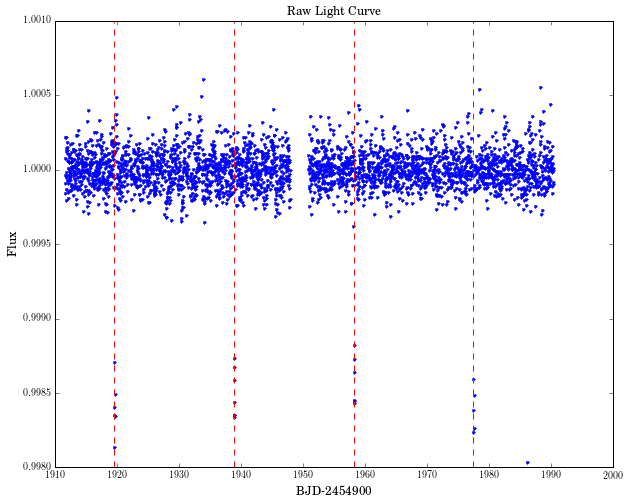

In [67]:
print transits
num_transits = len(transits)
plt.figure(2)
plt.plot(timeLC[goodP], fluxLC[goodP],'.')
plt.xlabel('BJD-2454900', fontsize=12)
plt.ylabel('Flux', fontsize=12)
plt.title('Raw Light Curve',fontsize=12)
for i in range(0,num_transits):
    plt.axvline(transits[i],color='r',ls='dashed')

Select the points that are "transit_window" hours to the left and to the right of the transit.

In [68]:
t=timeLC[goodP]
f=fluxLC[goodP]
transit_window = 8.0 #In hours
window = transit_window/24 # In days

sumPoints=0

for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   sumPoints=np.sum(selPoints)+sumPoints

#print sumPoints #Cantidad total de puntos en los 4 tránsitos en la franja que nos interesa

timeTrans = np.empty(sumPoints)
fluxTrans = np.empty(sumPoints)
flag = np.empty(sumPoints)
midTrans = np.empty(sumPoints)

sumPoints = 0
for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   numPoints = np.sum(selPoints)
   timeTrans[0+sumPoints:numPoints+sumPoints] = t[selPoints]
   fluxTrans[0+sumPoints:numPoints+sumPoints] = f[selPoints]
   flag[0+sumPoints:numPoints+sumPoints] = i
   midTrans[0+sumPoints:numPoints+sumPoints] = transits[i] 
   sumPoints = numPoints + sumPoints 

Plot the folded light curve.

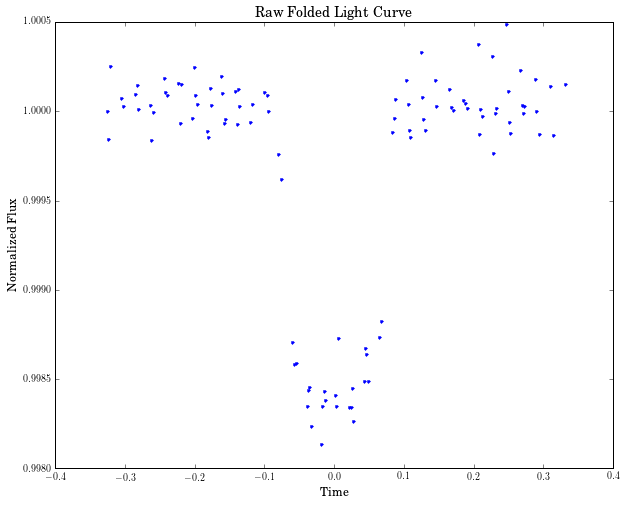

In [69]:
dt = timeTrans-midTrans
plt.plot(dt, fluxTrans,'.')
plt.title('Raw Folded Light Curve', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)

In [70]:
rangeTransit = 0.1
dataBool = np.abs(dt)>=rangeTransit # If true, point is outside of the transit.
out = (timeTrans<=rangeTransit) & (timeTrans>=rangeTransit) # This is a boolean array that tells you which points are outside of the transit.

Fit the regions outside each transit. Optional: Visualizing the linear fits. 

In [71]:
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)

Divide the "light curve" of each transit by the fit obtained in the previous window. Optional: Visualize the results.

In [72]:
corFlux=fluxTrans
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

The following parameters are the best estimates obtained from Part I.

In [73]:
os.chdir("/Users/mariona/Desktop/summer2015")

for file in glob.glob("PartI_finalparameters.txt"):
      parameters = np.loadtxt(file, skiprows=2)

depth_ml = parameters[0]
b_ml = parameters[1]
sigma_ml = parameters[3]
sumLD_ml = parameters[4]
mass_ml = parameters[5] #Best guess for mass of the star
radius_ml = parameters[6] #Best guess for radius of the star
f0_ml = parameters[7]

print depth_ml, b_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

0.0015669 0.62688 4.0383e-11 0.62054 0.92719 0.94092 1.0


Calculates the log of the likelihood of the transit model being the right model. The index i represents the transit being analyzed.

In [74]:
import transit
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass=pmass,radius=pradius))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [75]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius>0) and (pdepth>0):
        return 0.0
    return -np.inf

In [76]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [77]:
n3 = lambda *args: -lnprob(*args)

result = op.minimize(n3, [depth_ml, b_ml, 0.0, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml], 
                     args=(dt, corFlux, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')

depth_ml2, b_ml2, t0_ml2, sigma_ml2, sumLD_ml2, mass_ml2, radius_ml2, f0_ml2  = result["x"]

u1_ml2 = 0.5*(sumLD_ml2 + diffLD)
u2_ml2 = sumLD_ml2-u1_ml2

Optimization terminated successfully.
         Current function value: -864.972937
         Iterations: 184
         Function evaluations: 303


Print best guesses

In [78]:
print depth_ml2, b_ml2, t0_ml2, sigma_ml2, sumLD_ml2, mass_ml2, radius_ml2, f0_ml2

0.00156131280954 0.614820948318 0.000491109862853 4.17937687014e-11 0.584883184127 0.930204850767 0.929337003538 1.00000109682


Compute the LC integrated over a Kepler long cadence exposure time with the results obtained in minimization process.

In [79]:
s = transit.System(transit.Central(mu1=u1_ml2, mu2=u2_ml2, mass = mass_ml2, radius = radius_ml2))
body = transit.Body(r=np.sqrt(depth_ml2)*radius_ml2, period=period, t0=t0_ml2, b=b_ml2, e=ecc)
s.add_body(body)

t_theory = np.arange(-1, 1, tKep*0.01)
f_theory = s.light_curve(t_theory, texp=tKep, tol=1e-08, maxdepth=4)
f_theory = f_theory-1.0 + f0_ml2

Plot of the theoretical and the observed data on the same graph

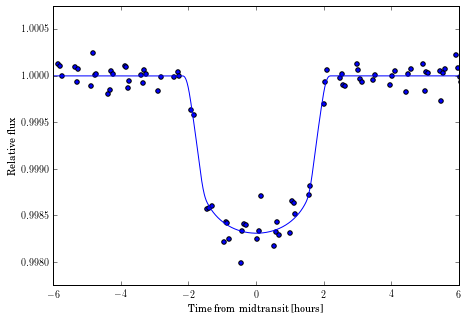

In [80]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*dt,corFlux)
plt.xlim([-6.0, 6.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24*t_theory, f_theory)

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

In [81]:
ndim, nwalkers = 8, 20
pos = [result["x"]*(1+1e-4*np.random.randn(ndim)) for i in range(nwalkers)]

In [82]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dt, corFlux, errorLC, allfixed))
st = 1000
sampler.run_mcmc(pos, st)

(array([[  1.22716953e-03,   4.62719122e-03,   1.10040737e-04,
           1.67315583e-09,   9.28161040e-01,   1.06163203e+00,
           8.55833510e-01,   1.00001196e+00],
        [  1.47851122e-03,   5.59527390e-01,   3.81514094e-03,
           1.22514646e-08,   5.03548930e-01,   8.80518770e-01,
           8.84908872e-01,   9.99983144e-01],
        [  1.55935461e-03,   5.57870981e-01,   3.48840261e-03,
           1.30777113e-08,   6.10330672e-01,   8.72635811e-01,
           8.48157449e-01,   9.99944924e-01],
        [  1.49407887e-03,   4.96236505e-01,  -1.95596099e-04,
           5.09661671e-09,   8.00057330e-01,   9.69612129e-01,
           8.89400281e-01,   1.00005195e+00],
        [  1.47133324e-03,   5.19430642e-01,   4.21237491e-04,
           6.43496134e-09,   7.88537063e-01,   9.69320053e-01,
           8.80658435e-01,   9.99972680e-01],
        [  1.26567893e-03,   3.61073174e-01,   8.89351073e-04,
           1.51815860e-08,   8.74786190e-01,   1.05291720e+00,
           8.9

In [83]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

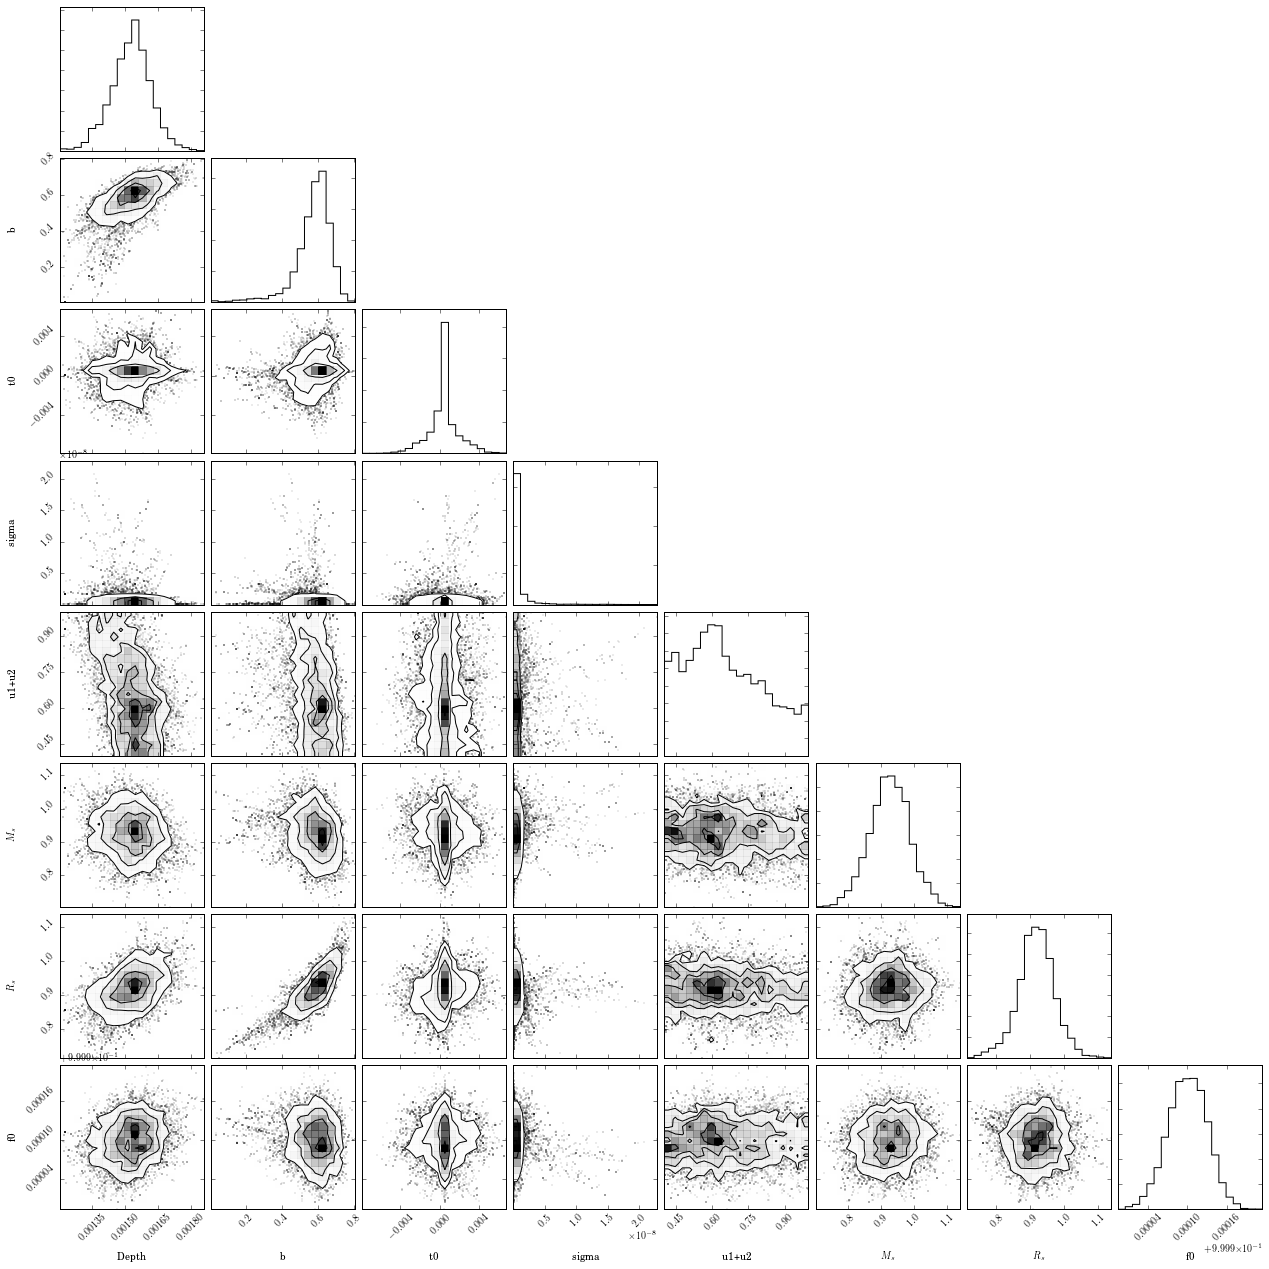

In [84]:
import triangle
fig = triangle.corner(samples, labels=["Depth", "b", "t0", "sigma", "u1+u2", "$M_s$", "$R_s$", "f0"]) #truths=[m_true, b_true, np.log(f_true)   , 
#fig.savefig("triangle.png")

Calculates the uncertainties based on the 16, 50th, and 84th percentiles of the samples in the marginalized distributions.

In [85]:
samples[:, 2] = np.exp(samples[:, 2])

planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.84, 50, 84.16], axis=0)))

v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

The planet radius in units of the Earth's radius and its +- errors.

In [86]:
planetrad_mcmc

(3.9164391470029218, 0.28207075003879334, 0.28608005267766057)

The inverse of the scaled semi-major axis is:

In [87]:
r_a_mcmc

(0.031140089511877501, 0.0017482821951379929, 0.0017684084130432098)

In [88]:
np.savetxt('PartIII_finalparameters.txt', (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc,
                                    radius_mcmc, f0_mcmc, planetrad_mcmc, r_a_mcmc), fmt='%.4e', delimiter='   ',
            header = """Parameters obtained from a fit to the Kepler data. The first column represents the 50% percentile
            of the MCMC posterior distribution, whereas the second (third) represents the +1 (-1) sigma uncertainty. In row 
            order, the parameters are: Depth, Impact parameter, time of transit, sigma (additional white noise), Flux uncertainty, Sum of LD coefficients, 
            Mass of the star, Radius of the star (gaussian priors on both), out of eclipse flux, Planet radius, R_s/a.""") 